In [11]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% ! important; }<style>"))

In [1]:
import matplotlib
%matplotlib notebook

import numpy as np
from astropy.io import fits
import matplotlib.pylab as plt
import os

from matplotlib import rcParams
import matplotlib as mpl

from matplotlib.ticker import MultipleLocator, FixedLocator
from matplotlib.gridspec import GridSpec
from astropy.table import Table
from scipy.interpolate import interp1d
from scipy.integrate import trapz

### some functions

In [2]:
from kapteyn import kmpfit


def poly4(p, x):
    a0, a1, a2, a3, a4 = p
    return a0+a1*x+a2*x**2+a3*x**3+a4*x**4


def resd_poly4(p, data):
    x, y, yerr = data
    model = poly4(p, x)
    return (y-model)/yerr


def poly3(p, x):
    a0, a1, a2, a3 = p
    return a0+a1*x+a2*x**2+a3*x**3


def resd_poly3(p, data):
    x, y, yerr = data
    model = poly3(p, x)
    return (y-model)/yerr


def poly5(p, x):
    a0, a1, a2, a3, a4, a5 = p
    return a0+a1*x+a2*x**2+a3*x**3+a4*x**4+a5*x**5


def resd_poly5(p, data):
    x, y, yerr = data
    model = poly5(p, x)
    return (y-model)/yerr


def polyfit(x, y, yerr, polyorder):

    fitdata = [x, y, yerr]
    if polyorder not in [3, 4, 5]:
        raise ValueError("the polynomial orders options: 3,4,5")
    else:
        if polyorder == 3:
            resd_poly = resd_poly3
            polymodel = poly3
            params0 = [1, 0, 0, 0]
        if polyorder == 4:
            resd_poly = resd_poly4
            polymodel = poly4
            params0 = [1, 0, 0, 0, 0]
        if polyorder == 5:
            resd_poly = resd_poly5
            polymodel = poly5
            params0 = [1, 0, 0, 0, 0, 0]

    fitobj = kmpfit.Fitter(residuals=resd_poly, data=fitdata)

    # print "Input fit data: "
    # print fitdata
    fitobj.fit(params0=params0)

    return fitobj

def single_gaussian(p, x):
    '''
    INPUTS:
            p: a sequence of parameters, amplitude, center, dispersion and zerolevel
            x: indepedent variable
    '''

    A, mu, sigma, zerolev = p
    return (A*np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma)) + zerolev)


def multi_gaussians(p, x, ncomp):
    '''
    INPUTS:
            p: a sequence of parameters, (amplitude, center, dispersion)*ncomp  and zerolevel
            x: indepedent variable
            ncomp: components number
    '''

    y = 0.0
    zerolev = p[-1]

    for i in range(ncomp):
        A, mu, sigma = p[i*3:(i+1)*3]
        y += A*np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

    return y + zerolev


def residuals_sG(p, data):
    '''
    multiple gaussians 
    '''
    x, y, yerr = data
    model = single_gaussian(p, x)
    return (y-model)/yerr


def spec_1gaussian_fitting(x, y, yerr, params0, display=True, fix_par_inds=None, show_yerr=False, verbose=1):
    '''
    Two components gaussian fitting
    '''
    fitdata = [x, y, yerr]
    fitobj = kmpfit.Fitter(residuals=residuals_sG, data=fitdata)

    if fix_par_inds is not None:
        fitobj.parinfo = []
        for param in params0:
            fitobj.parinfo.append({})
        for ind in fix_par_inds:
            print(("parameter #%s will be fixed" % ind))
            fitobj.parinfo[ind]['fixed'] = True
            print((fitobj.parinfo))

    fitobj.fit(params0=params0)

    if (fitobj.status <= 0):
        print(('error message =', fitobj.errmsg))
        raise SystemExit

    if verbose:
        print(("Params:        ", fitobj.params))
        print(("Errors from covariance matrix         : ", fitobj.xerror))
        print(("Uncertainties assuming reduced Chi^2=1: ", fitobj.stderr))
        print(("Chi^2 min:     ", fitobj.chi2_min))

    pfits = fitobj.params
    stderrs = fitobj.stderr

    if display:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.plot(x, y, 'b', label='data')
        if show_yerr:
            ax.errorbar(x, y, yerr=yerr, fmt='b.', label='data')
        flux_fit = single_gaussian(pfits, x)

        p1 = [pfits[0], pfits[1], pfits[2], pfits[-1]]
        comp1 = single_gaussian(p1, x)

        ax.plot(x, comp1, 'co', label='component 1')

        ax.plot(x, flux_fit, 'r', linewidth=2, label='all')

        plt.legend()
        plt.show()

    return pfits, stderrs


def residuals_twoG(p, data):
    ''' 
    multiple gaussians 
    '''
    x, y, yerr = data
    model = multi_gaussians(p, x, 2)
    return (y-model)/yerr


def spec_2gaussians_fitting(x, y, yerr, params0, display=True, baselinefixed=False):
    '''
    Two components gaussian fitting
    '''
    fitdata = [x, y, yerr]
    fitobj = kmpfit.Fitter(residuals=residuals_twoG, data=fitdata)
    if baselinefixed:
        fitobj.parinfo = [{'fixed': False}]*6+[{'fixed': True}]
    fitobj.fit(params0=params0)

    if (fitobj.status <= 0):
        print(('error message =', fitobj.errmsg))
        raise SystemExit

    print(("Params:        ", fitobj.params))
    print(("Errors from covariance matrix         : ", fitobj.xerror))
    print(("Uncertainties assuming reduced Chi^2=1: ", fitobj.stderr))
    print(("Chi^2 min:     ", fitobj.chi2_min))

    pfits = fitobj.params
    stderrs = fitobj.stderr

    if display:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.plot(x, y, 'b', label='data')
        flux_fit = multi_gaussians(pfits, x, 2)

        p1 = [pfits[0], pfits[1], pfits[2], pfits[-1]]
        p2 = [pfits[3], pfits[4], pfits[5], pfits[-1]]
        comp1 = single_gaussian(p1, x)
        comp2 = single_gaussian(p2, x)

        ax.plot(x, comp1, 'co', label='component 1')
        ax.plot(x, comp2, 'ko', label='component 2')

        ax.plot(x, flux_fit, 'r', linewidth=2, label='all')

        plt.legend()
        plt.show()

    return pfits, stderrs


def single_lorentzian(p, x):
    h, c, w, zerolev = p
    return h/(1+((x-c)/w)**2)+zerolev


def residuals_sL(p, data):
    ''' 
    multiple gaussians 
    '''
    x, y, yerr = data
    model = single_lorentzian(p, x)
    return (y-model)/yerr


def spec_lorentzian_fitting(x, y, yerr, params0, display=True, fix_par_inds=None, show_yerr=False):
    fitdata = [x, y, yerr]
    fitobj = kmpfit.Fitter(residuals=residuals_sL, data=fitdata)
    if fix_par_inds is not None:
        fitobj.parinfo = []
        for param in params0:
            fitobj.parinfo.append({})
        for ind in fix_par_inds:
            print("parameter #%s will be fixed" % ind)
            fitobj.parinfo[ind]['fixed'] = True
            print(fitobj.parinfo)

    fitobj.fit(params0=params0)

    if (fitobj.status <= 0):
        print(('error message =', fitobj.errmsg))
        raise SystemExit

    print(("Params:        ", fitobj.params))
    print(("Errors from covariance matrix         : ", fitobj.xerror))
    print(("Uncertainties assuming reduced Chi^2=1: ", fitobj.stderr))
    print(("Chi^2 min:     ", fitobj.chi2_min))

    pfits = fitobj.params
    stderrs = fitobj.stderr

    if display:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.plot(x, y, 'b', label='data')
        if show_yerr:
            ax.errorbar(x, y, yerr=yerr, fmt='b.', label='data')
        flux_fit = single_lorentzian(pfits, x)

        p1 = [pfits[0], pfits[1], pfits[2], pfits[-1]]
        comp1 = single_lorentzian(p1, x)

        ax.plot(x, comp1, 'co', label='component 1')

        ax.plot(x, flux_fit, 'r', linewidth=2, label='all')

        plt.legend()
        plt.show()

    return pfits, stderrs


def gas_emission_and_stellar_absorption(p, x):
    ''' 
    INPUTS:
            p: a sequence of parameters, amplitude, center, dispersion and zerolevel
            x: indepedent variable
    '''

    A, mu, sigma, h, c, w, zerolev = p
    return A*np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma)) + zerolev + h/(1+((x-c)/w)**2)


def residuals_lorentzian_gaussian(p, data):
    ''' 
    multiple gaussians 
    '''
    x, y, yerr = data
    model = gas_emission_and_stellar_absorption(p, x)
    return (y-model)/yerr


def spec_emission_and_absorption_fitting(x, y, yerr, params0, display=True, fix_par_inds=None, show_yerr=False):
    fitdata = [x, y, yerr]
    fitobj = kmpfit.Fitter(
        residuals=residuals_lorentzian_gaussian, data=fitdata)
    if fix_par_inds is not None:
        fitobj.parinfo = []
        for param in params0:
            fitobj.parinfo.append({})
        for ind in fix_par_inds:
            print("parameter #%s will be fixed" % ind)
            fitobj.parinfo[ind]['fixed'] = True
            print(fitobj.parinfo)

    fitobj.fit(params0=params0)

    if (fitobj.status <= 0):
        print('error message =', fitobj.errmsg)
        raise SystemExit

    print("Params:        ", fitobj.params)
    print("Errors from covariance matrix         : ", fitobj.xerror)
    print("Uncertainties assuming reduced Chi^2=1: ", fitobj.stderr)
    print("Chi^2 min:     ", fitobj.chi2_min)

    pfits = fitobj.params
    stderrs = fitobj.stderr

    if display:
        fig, ax = plt.subplots(figsize=(8, 8))
        if show_yerr:
            ax.errorbar(x, y, yerr=yerr, fmt='b.', label='data')
        else:
            ax.plot(x, y, 'b', label='data')
        flux_fit = gas_emission_and_stellar_absorption(pfits, x)

        p1 = [pfits[0], pfits[1], pfits[2], 0]
        comp1 = single_gaussian(p1, x)
        ax.plot(x, comp1, 'c', label='gas emission')
        p2 = [pfits[3], pfits[4], pfits[5], pfits[-1]]
        comp2 = single_lorentzian(p2, x)
        ax.plot(x, comp2, 'g', label='stellar absorption')

        ax.plot(x, flux_fit, 'r', linewidth=2, label='all')

        plt.legend()
        plt.show()

    return pfits, stderrs


def multi_gaussians(p, x, ncomp):
    ''' 
    INPUTS:
            p: a sequence of parameters, (amplitude, center, dispersion)*ncomp  and zerolevel
            x: indepedent variable
            ncomp: components number
    '''

    y = 0.0
    zerolev = p[-1]

    for i in range(ncomp):
        A, mu, sigma = p[i*3:(i+1)*3]
        y += A*np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

    return y + zerolev


def residuals_three(p, data):
    ''' 
    multiple gaussians 
    '''
    x, y, yerr = data
    model = multi_gaussians(p, x, 3)
    return (y-model)/yerr






def spec_3gaussians_fitting(x, y, yerr, params0, display=True, fix_par_inds=None):
    ''' 
    three components gaussian fitting
    '''
    fitdata = [x, y, yerr]
    fitobj = kmpfit.Fitter(residuals=residuals_three, data=fitdata)
    if fix_par_inds is not None:
        fitobj.parinfo = []
        for param in params0:
            fitobj.parinfo.append({})
        for ind in fix_par_inds:
            print("parameter #%s will be fixed" % ind)
            fitobj.parinfo[ind]['fixed'] = True
            print(fitobj.parinfo)

    fitobj.parinfo[0]['limits'] = (0,None)
    fitobj.parinfo[3]['limits'] = (0,None)
    fitobj.parinfo[6]['limits'] = (0,None)
    
    print(fitobj.parinfo)
            
    fitobj.fit(params0=params0)

    if (fitobj.status <= 0):
        print('error message =', fitobj.errmsg)
        raise SystemExit

    print("Params:        ", fitobj.params)
    print("Errors from covariance matrix         : ", fitobj.xerror)
    print("Uncertainties assuming reduced Chi^2=1: ", fitobj.stderr)
    print("Chi^2 min:     ", fitobj.chi2_min)

    pfits = fitobj.params
    stderrs = fitobj.stderr

    if display:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.plot(x, y, 'b', label='data')
        flux_fit = multi_gaussians(pfits, x, 3)

        p1 = [pfits[0], pfits[1], pfits[2], pfits[-1]]
        p2 = [pfits[3], pfits[4], pfits[5], pfits[-1]]
        p3 = [pfits[6], pfits[7], pfits[8], pfits[-1]]
        comp1 = single_gaussian(p1, x)
        comp2 = single_gaussian(p2, x)
        comp3 = single_gaussian(p3, x)
        ax.plot(x, comp1, 'co', label='component 1')
        ax.plot(x, comp2, 'ko', label='component 2')
        ax.plot(x, comp3, 'mo', label='component 3')
        ax.plot(x, flux_fit, 'r', linewidth=2, label='all')

        plt.legend()
        plt.show()

    return pfits, stderrs




In [3]:
def sigma_clipping(data, sig=3, meanfunc=np.median, display_result=False):
    """
    Identify outliers considering the mean (if meanfunc=np.mean) or median (if meanfunc=np.median) value and 3 sigma (3*stdev),
    iterating until convergence.
    """
    last_total = len(data)
    # First iteration
    stdev = np.std(data)
    diff = data - meanfunc(data)
    sfilter = np.abs(diff) < sig*stdev
    current_total = len(data[sfilter])
    # Continue iterating until convergence (no more points are removed)
    while last_total > current_total:
        # print current_total, stdev
        last_total = current_total
        stdev = np.std(data[sfilter])
        diff = data - meanfunc(data[sfilter])
        sfilter = np.abs(diff) < sig*stdev
        current_total = len(data[sfilter])

    if display_result:
        import matplotlib.pylab as plt

        plt.plot(data, 'ko', label='Original')
        plt.plot(data[sfilter], 'ro', label='after clipping')
        plt.legend()
        plt.show()

    return data[sfilter], sfilter, stdev

def binning_with_sigma_clipping(x, y, dt, yerr=None,  useBinCenter=True, useMeanX=False,  removeEmpty=True, removeNoError=False):
    '''
    same algorithm with simple binning in PyAstronomy, but perform signal clipping in each bin first
    '''

    x0 = np.min(x)
    inWhichBin = np.floor((x-x0)/dt)

    nbins = int(np.max(inWhichBin)) + 1
    bwd = np.unique(inWhichBin)

    print(nbins)

    result = np.empty((nbins, 4))
    result[:] = np.NAN

    result[:, 0] = x0 + np.arange(nbins)*dt

    if useBinCenter:
        result[:, 0] += 0.5*dt

    for b in bwd:
        b = int(b)
        # print result

        # print b
        indi = np.where(inWhichBin == b)[0]
        # print indi
        # print result[b,3]
        result[b, 3] = len(indi)

        y_thisbin = y[indi]

        y_clipped, safeindex, stddev = sigma_clipping(y_thisbin, sig=3, meanfunc=np.mean, display_result=False)

        result[b, 1] = np.mean(y_clipped)

        if useMeanX:
            result[b, 0] = np.mean(x[indi])

        if useMeanX:
            result[b, 0] = np.mean(x[indi])
        if yerr is None:
            # No errors on data points are given
            if len(indi) > 1:
                result[b, 2] = np.std(y[indi]) / np.sqrt(result[b, 3])
            else:
              # No error if there is only a single point in the bin
                result[b, 2] = np.NAN
        else:
            # There are errors on the data points
            # Use error propagation
            result[b, 2] = np.sqrt(np.sum(yerr[indi]**2)) / result[b, 3]

    if removeEmpty:
        # Remove bins without data points in it
        indi = np.where(np.invert(np.isnan(result[:, 1])))[0]
        result = result[indi, :]

    if removeNoError:
        # Remove bins for which no error can be given
        indi = np.where(np.invert(np.isnan(result[:, 2])))[0]
        result = result[indi, :]

    return result




## load the spectra

In [7]:
z = 0.0055
z_22jli = 0.0055

In [4]:
#prepare spectral template

import pickle

#if previous saved result available
outfile = '../data/spectra/2022jli.20230301.p'
with open(outfile, 'rb') as fp:
    specs_22jli = pickle.load(fp)

spectable = specs_22jli['spectable']
spectable.sort('phase')



In [5]:
spectable.show_in_notebook()

## Host absorption lines and extinction

### Na I 

<IPython.core.display.Javascript object>


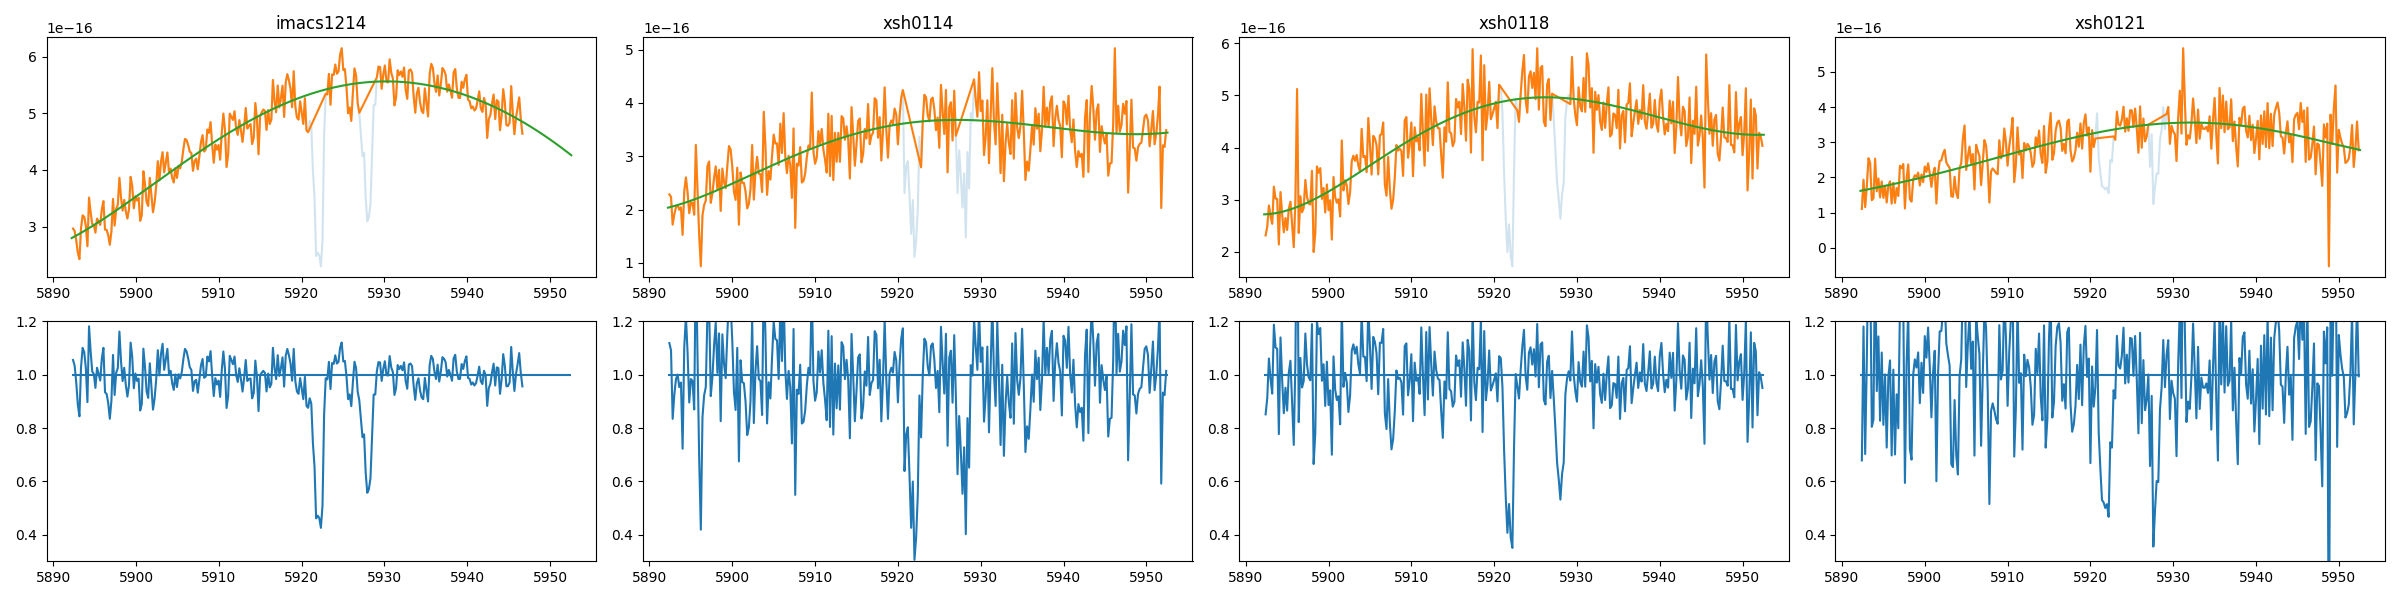

In [10]:
### host galaxy


specnames = ['imacs1214','xsh0114', 'xsh0118', 'xsh0121']

fig, axes = plt.subplots(2,len(specnames),figsize=(24,6))


for i, specname in enumerate(specnames):
    spec = specs_22jli[specname]['spec']
    phase = specs_22jli[specname]['phase']
    xs = spec[:,0]
    ys = spec[:,1]
    yserr = np.ones_like(ys)*np.mean(ys)*0.05

    w1 = 5860*(1+z_22jli)
    w2 = 5920*(1+z_22jli)

    regmask = (xs>w1)*(xs<w2)
    xs = xs[regmask]
    ys = ys[regmask]
    yserr = yserr[regmask]

    fitmask =  np.ones_like(xs, dtype=bool)

    D2_w = 5889.4*(1+z_22jli)
    D1_w = 5895.6*(1+z_22jli)
    line_halfwidth = 1.0

    fitmask[(xs>(D1_w-line_halfwidth))*(xs<(D1_w+line_halfwidth))] = False
    fitmask[(xs>(D2_w-line_halfwidth))*(xs<(D2_w+line_halfwidth))] = False

    xsfit = xs[fitmask]
    ysfit = ys[fitmask]
    yserrfit = yserr[fitmask]


    #print(xsfit-np.mean(xsfit))
    #print(ysfit/np.max(ysfit))
    #print(yserrfit/np.max(ysfit))

    fitobj = polyfit(xsfit-np.mean(xsfit), ysfit/np.max(ysfit), yserrfit/np.max(ysfit), 5)

    ax = axes[0,i]
    ax.plot(xs, ys, alpha=0.2)
    ax.plot(xsfit, ysfit)
    ax.plot(np.linspace(w1, w2, 200), poly5(fitobj.params, np.linspace(w1, w2, 200)-np.mean(xsfit)) *np.max(ysfit) )
    ax.set_title(specname)
    
    ys_norm =  ys / (poly5(fitobj.params, xs-np.mean(xsfit)) *np.max(ysfit) )
    specnorm = np.array([xs, ys_norm]).transpose()
    np.savetxt('../data/spectra/%s_sodium_region_norm_host.txt'%specname, specnorm)

    ax2 = axes[1,i]
    ax2.plot(xs, ys_norm)
    ax2.hlines(1, xmin=w1, xmax=w2)
    ax2.set_ylim([0.3, 1.2])
    
plt.tight_layout()

<IPython.core.display.Javascript object>


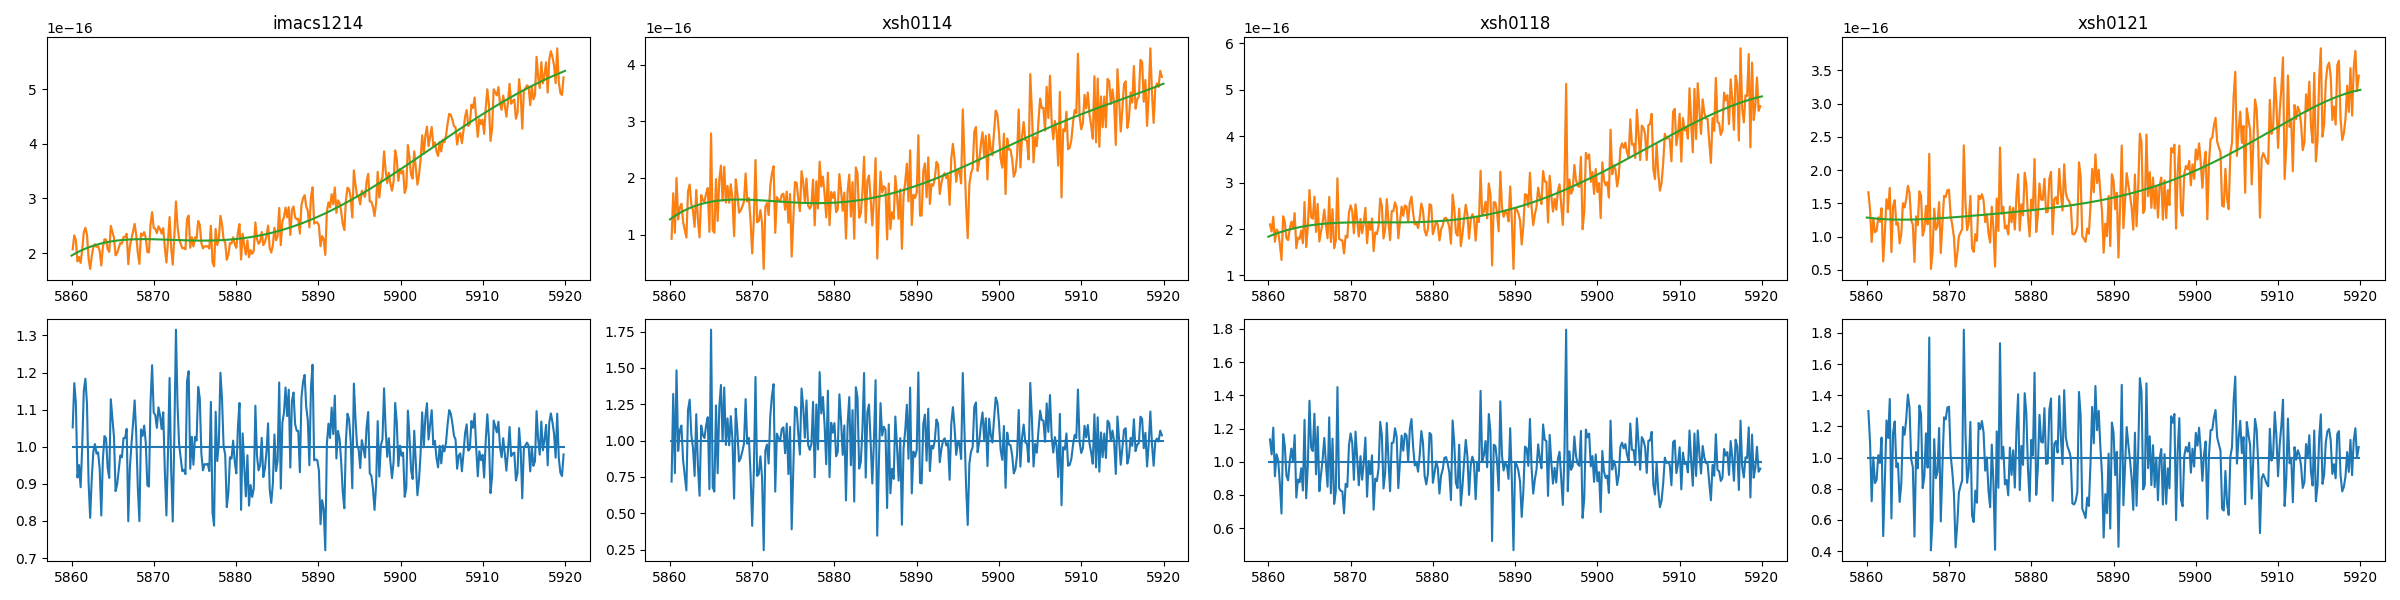

In [12]:
### Galactic

specnames = ['imacs1214','xsh0114', 'xsh0118', 'xsh0121']

fig, axes = plt.subplots(2,len(specnames),figsize=(24,6))


for i, specname in enumerate(specnames):
    spec = specs_22jli[specname]['spec']
    phase = specs_22jli[specname]['phase']
    xs = spec[:,0]
    ys = spec[:,1]
    yserr = np.ones_like(ys)*np.mean(ys)*0.05

    w1 = 5860
    w2 = 5920

    regmask = (xs>w1)*(xs<w2)
    xs = xs[regmask]
    ys = ys[regmask]
    yserr = yserr[regmask]

    fitmask =  np.ones_like(xs, dtype=bool)

    D2_w = 5889.4*(1+z_22jli)
    D1_w = 5895.6*(1+z_22jli)
    line_halfwidth = 1

    fitmask[(xs>(D1_w-line_halfwidth))*(xs<(D1_w+line_halfwidth))] = False
    fitmask[(xs>(D2_w-line_halfwidth))*(xs<(D2_w+line_halfwidth))] = False

    xsfit = xs[fitmask]
    ysfit = ys[fitmask]
    yserrfit = yserr[fitmask]


    #print(xsfit-np.mean(xsfit))
    #print(ysfit/np.max(ysfit))
    #print(yserrfit/np.max(ysfit))

    fitobj = polyfit(xsfit-np.mean(xsfit), ysfit/np.max(ysfit), yserrfit/np.max(ysfit), 5)

    ax = axes[0,i]

    ax.plot(xs, ys, alpha=0.2)
    ax.plot(xsfit, ysfit)
    ax.plot(np.linspace(w1, w2, 200), poly5(fitobj.params, np.linspace(w1, w2, 200)-np.mean(xsfit)) *np.max(ysfit) )

    
    
    ys_norm =  ys / (poly5(fitobj.params, xs-np.mean(xsfit)) *np.max(ysfit) )
    specnorm = np.array([xs, ys_norm]).transpose()
    np.savetxt('../data/spectra/%s_sodium_region_norm_mw.txt'%specname, specnorm)

    ax2 = axes[1,i]
    ax2.plot(xs, ys_norm)
    ax2.hlines(1, xmin=w1, xmax=w2)
    
    ax.set_title(specname)
    
plt.tight_layout()

EW(D1+D2): 1.1559712546983867
EW(D1+D2): 1.1054373936407296
EW(D1+D2): 0.914564605790734
EW(D1+D2): 1.1130109281461849


<IPython.core.display.Javascript object>


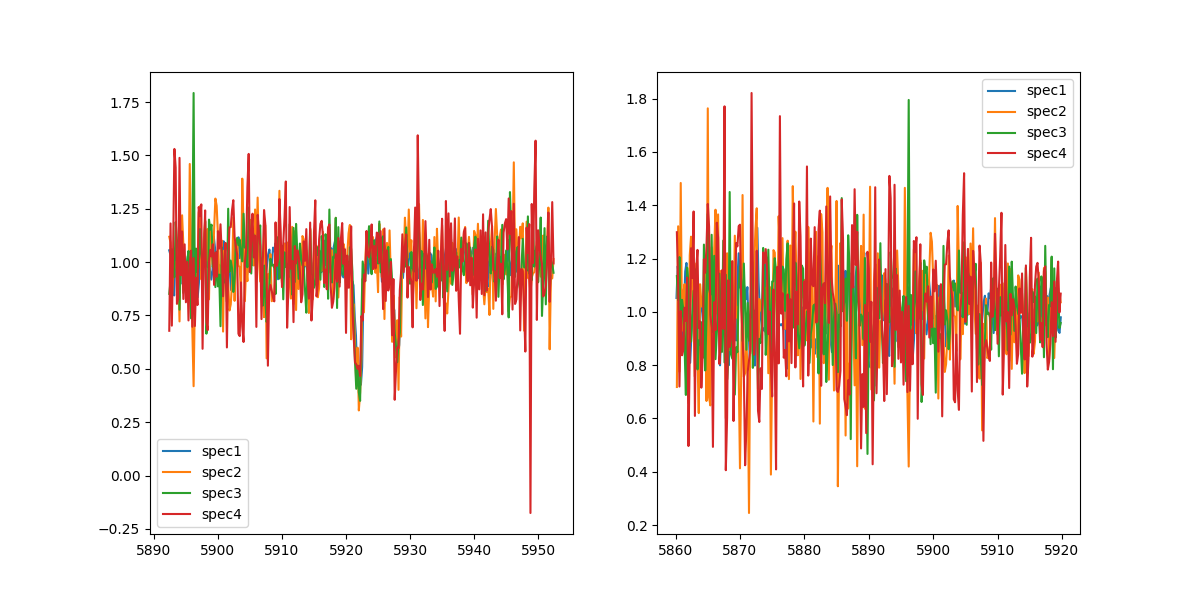

<IPython.core.display.Javascript object>


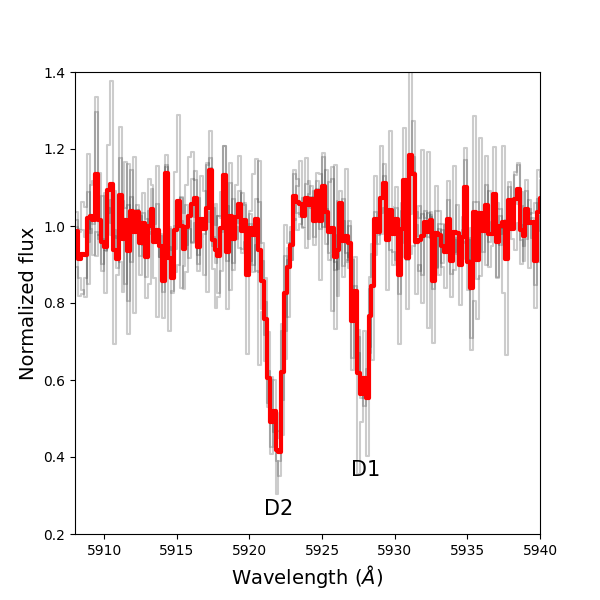

uncertainty per pixel
0.06385675978873363
0.07932064756771179
EW(D1+D2): 1.071983681556348
0.11302381901364628


<IPython.core.display.Javascript object>


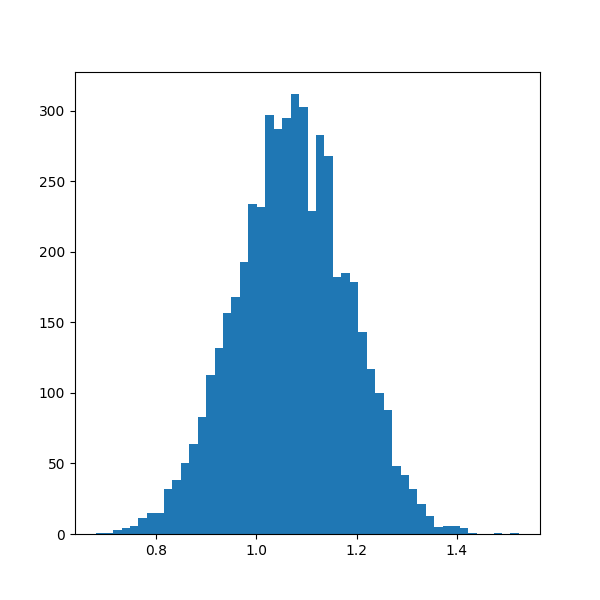

EW(D1): 0.46749631216404314


<IPython.core.display.Javascript object>


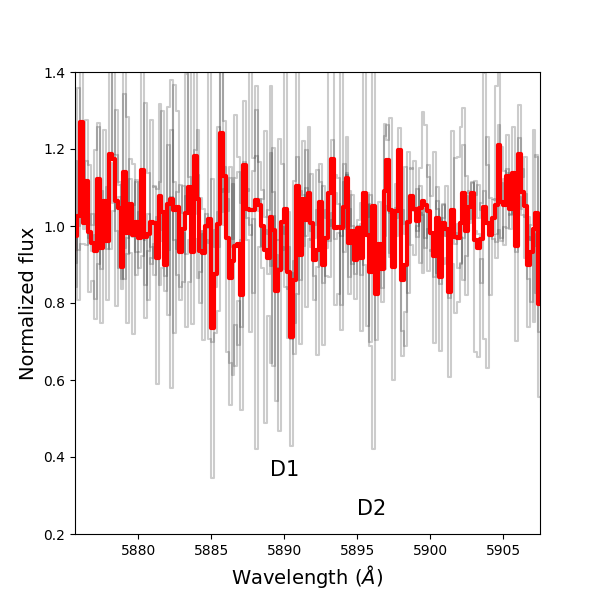

In [14]:
    
##D1+D2
wmin = 5915
wmax = 5933


spec1 = np.loadtxt('../data/spectra/imacs1214_sodium_region_norm_host.txt')
spec2 = np.loadtxt('../data/spectra/xsh0114_sodium_region_norm_host.txt')
spec3 = np.loadtxt('../data/spectra/xsh0118_sodium_region_norm_host.txt')
spec4 = np.loadtxt('../data/spectra/xsh0121_sodium_region_norm_host.txt')

#calculate EW from individual spectrum
for specdata in [spec1, spec2, spec3, spec4]:
    wavelength = specdata[:,0]
    flux = specdata[:,1]
    mask = (wavelength>wmin)*(wavelength<wmax)
    wavelength = wavelength[mask]
    flux = flux[mask]

    #sort the spectrum data, wavelength low to high
    sort_index = np.argsort(wavelength)
    wavelength  = wavelength[sort_index]
    flux = flux[sort_index]
    baseline = np.ones(len(wavelength))
    flux_net = 1.0 - flux
    EW = trapz(flux_net, x=wavelength)

    print('EW(D1+D2):', EW)
    

spec1_mw = np.loadtxt('../data/spectra/imacs1214_sodium_region_norm_mw.txt')
spec2_mw = np.loadtxt('../data/spectra/xsh0114_sodium_region_norm_mw.txt')
spec3_mw = np.loadtxt('../data/spectra/xsh0118_sodium_region_norm_mw.txt')
spec4_mw = np.loadtxt('../data/spectra/xsh0121_sodium_region_norm_mw.txt')


fig, (ax, ax2) = plt.subplots(1,2, figsize=(12,6))
ax.plot(spec1[:,0], spec1[:,1], label='spec1')
ax.plot(spec2[:,0], spec2[:,1], label='spec2')
ax.plot(spec3[:,0], spec3[:,1], label='spec3')
ax.plot(spec4[:,0], spec4[:,1], label='spec4')

ax.legend(loc=0)

specs_NaID = [spec1, spec2, spec3, spec4]
wavelength = spec2[:,0] #reference wavelength
 

ax2.plot(spec1_mw[:,0], spec1_mw[:,1], label='spec1')
ax2.plot(spec2_mw[:,0], spec2_mw[:,1], label='spec2')
ax2.plot(spec3_mw[:,0], spec3_mw[:,1], label='spec3')
ax2.plot(spec4_mw[:,0], spec4_mw[:,1], label='spec4')

ax2.legend(loc=0)

specs_NaID_mw = [spec1_mw, spec2_mw, spec3_mw, spec4_mw]
wavelength_mw = spec2_mw[:,0] #reference wavelength
    


fig, ax = plt.subplots(figsize=(6,6))

spec_fluxs = []

for spec in specs_NaID:
    spec_interpfunc = interp1d(spec[:,0], spec[:,1], bounds_error=False, fill_value='extrapolate')
    flux_interp = spec_interpfunc(wavelength)
    spec_fluxs.append(flux_interp)
    
    ax.step(wavelength, flux_interp, alpha=0.2, color='k')
    
flux = np.average(np.array(spec_fluxs).transpose(), axis=1)

ax.step(wavelength, flux, 'r', lw=3)  

ax.text(5928, 0.35, 'D1', fontsize=15, ha='center')
ax.text(5922, 0.25, 'D2', fontsize=15, ha='center')

ax.set_xlim([5908, 5940])
ax.set_ylim([0.2, 1.4])
ax.set_xlabel('Wavelength ($\AA$)', fontsize=14)
ax.set_ylabel('Normalized flux', fontsize=14)


plt.savefig('../plots/host_galaxy_NaID_lines.pdf')





print('uncertainty per pixel')
print(np.std(flux[(wavelength>5930)*(wavelength<5945)]))
print(np.std(flux[wavelength<5920]))


##Calculate EW from the averaged spectrum
mask = (wavelength>wmin)*(wavelength<wmax)
wavelength = wavelength[mask]
flux = flux[mask]
#sort the spectrum data, wavelength low to high
sort_index = np.argsort(wavelength)
wavelength  = wavelength[sort_index]
flux = flux[sort_index]
baseline = np.ones(len(wavelength))
flux_net = baseline - flux
EW = trapz(flux_net, x=wavelength)

print('EW(D1+D2):', EW)



#do some estimate on the uncertainty of the measured EW



EWs_mcmc = []
for i in range(5000):
    flux_temp = flux.copy()
    flux_temp = flux_temp + np.random.randn(len(flux))*0.06
    
    mask = (wavelength>wmin)*(wavelength<wmax)
    wavelength = wavelength[mask]
    flux_temp = flux_temp[mask]
    #sort the spectrum data, wavelength low to high
    sort_index = np.argsort(wavelength)
    wavelength  = wavelength[sort_index]
    flux_temp = flux_temp[sort_index]
    baseline = np.ones(len(wavelength))
    flux_net = baseline - flux_temp
    EW = trapz(flux_net, x=wavelength)
    EWs_mcmc.append(EW)
print(np.std(EWs_mcmc))
    
fig,ax = plt.subplots(figsize=(6,6))
ax.hist(EWs_mcmc, bins=50)


## D2
'''
wmin = 5915
wmax = 5925
baseline = 1
absorption = 1
mask = (wavelength>wmin)*(wavelength<wmax)
wavelength = wavelength[mask]
flux = flux[mask]

#sort the spectrum data, wavelength low to high
sort_index = np.argsort(wavelength)
wavelength  = wavelength[sort_index]
flux = flux[sort_index]


if baseline != 1:
        raise ValueError("we don't support non-normalized spectrum yet... please normalize your spectrum first please")
else:
        baseline = np.ones(len(wavelength))
    
if absorption:
        flux_net = baseline - flux
else:
        flux_net = flux - baseline

EW = trapz(flux_net, x=wavelength)

print('EW(D2):', EW)
'''


## D1
wmin = 5925
wmax = 5933
mask = (wavelength>wmin)*(wavelength<wmax)
wavelength = wavelength[mask]
flux = flux[mask]

#sort the spectrum data, wavelength low to high
sort_index = np.argsort(wavelength)
wavelength  = wavelength[sort_index]
flux = flux[sort_index]
baseline = np.ones(len(wavelength))
flux_net = 1 - flux

EW = trapz(flux_net, x=wavelength)

print('EW(D1):', EW)





fig, ax = plt.subplots(figsize=(6,6))

spec_fluxs = []

for spec in specs_NaID_mw:
    spec_interpfunc = interp1d(spec[:,0], spec[:,1], bounds_error=False, fill_value='extrapolate')
    flux_interp = spec_interpfunc(wavelength_mw)
    spec_fluxs.append(flux_interp)
    
    ax.step(wavelength_mw, flux_interp, alpha=0.2, color='k')
    
flux = np.average(np.array(spec_fluxs).transpose(), axis=1)

ax.step(wavelength_mw, flux, 'r', lw=3)  

ax.text(5890, 0.35, 'D1', fontsize=15, ha='center')
ax.text(5896, 0.25, 'D2', fontsize=15, ha='center')

ax.set_xlim(np.array([5908, 5940])/(1+z_22jli))
ax.set_ylim([0.2, 1.4])
ax.set_xlabel('Wavelength ($\AA$)', fontsize=14)
ax.set_ylabel('Normalized flux', fontsize=14)


plt.savefig('../plots/MW_NaID_lines.pdf')



### Diffusion interstellar band


The flux of the background luminition source matters when it comes to detect DIB absorption 


The strong DIB 5780 was not detected could be simply because the continuum flux around 5780 is low and the absorption feature is buried in the noise.




Num  <Wave> e_<Wave> SD<Wave> ...  D/L/R     DetPct              Com            
     0.1 nm  0.1 nm   km / s  ...                                               
--- ------- -------- -------- ... ------- ----------- --------------------------
  1 4259.00     0.16    11.44 ...  14/3/8 56.0%/82.4%                         --
  2 4363.83     0.04     2.52 ... 12/12/1 48.0%/50.0%                         --
  3 4371.60     0.19    12.73 ...  7/6/12 28.0%/53.8%                         --
  4 4429.33     1.34    90.63 ...  20/3/2 80.0%/87.0% Broad DIB confirmed in S18
  5 4494.53     0.38    25.62 ...  8/11/6 32.0%/42.1%                         --
  6 4501.51     0.16    10.49 ...  18/1/6 72.0%/94.7%        Split into two DIBs
  7 4504.45     0.18    11.99 ... 12/11/2 48.0%/52.2%                         --
  8 4659.86     0.05      3.4 ... 10/12/3 40.0%/45.5%                         --
  9 4668.66     0.12     7.75 ...  14/6/5 56.0%/70.0%                         --
 10 4680.24     0.07     4.2

<IPython.core.display.Javascript object>


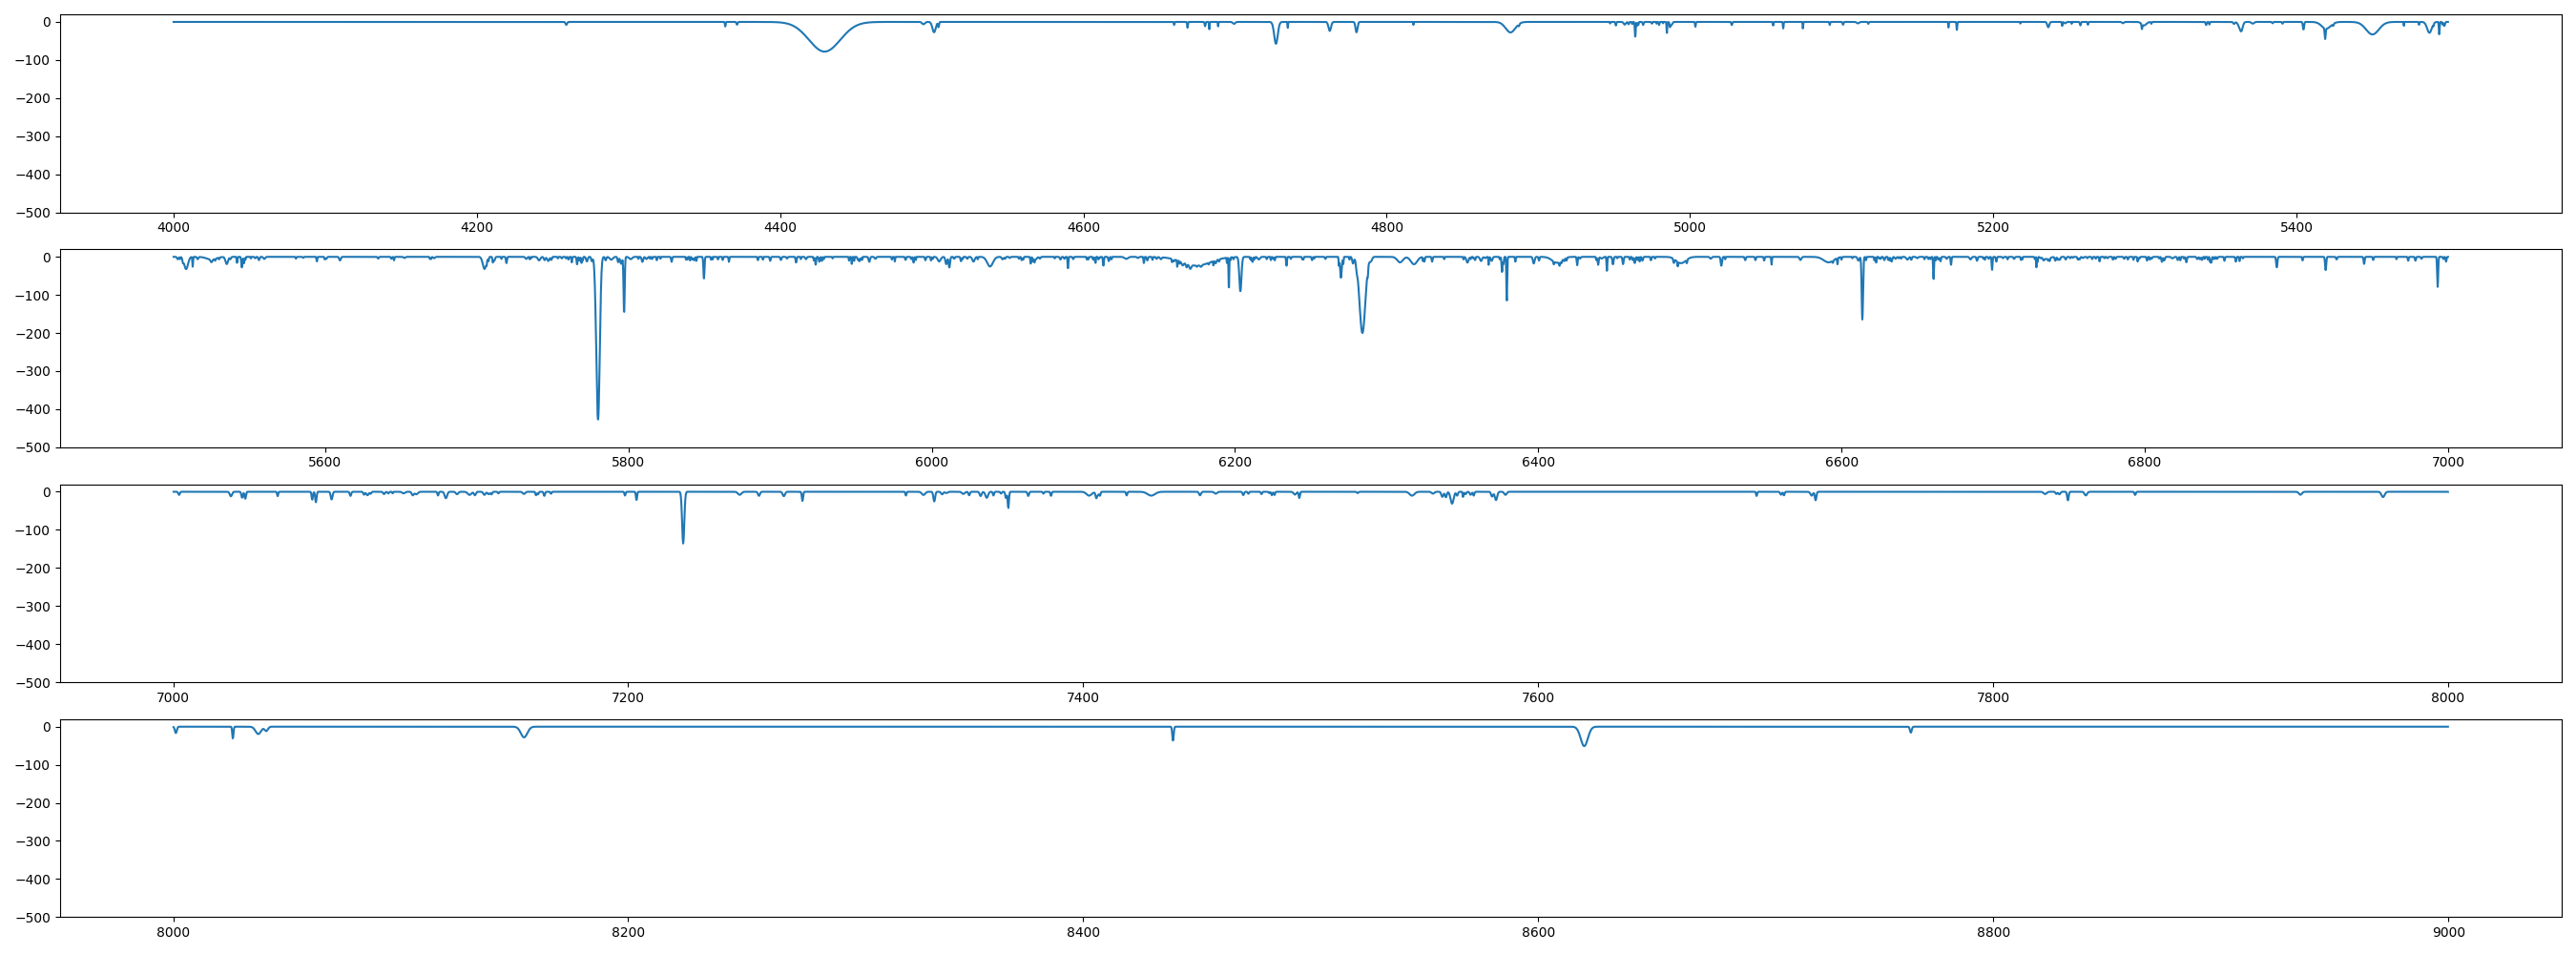

In [16]:
dibfile = '../data/table_from_literature/apjab1b74t2_mrt.txt'
dib  = Table.read('../data/table_from_literature/apjab1b74t2_mrt.txt', format='ascii.cds')


linelist = Table.read(dibfile, format='ascii.cds')
print(linelist)
linelist = linelist[~linelist['<Wave>'].mask]
linelist = linelist[~linelist['<EW/EBV>'].mask]
linelist = linelist[~linelist['<FWHM>'].mask]
pixelscale = 0.2
w1= 4000
w2= 9000


xs = np.linspace(w1, w2, num=int((w2-w1)/pixelscale))
ys = np.zeros(len(xs))

for i, (y,x,fwhm) in enumerate(linelist[['<EW/EBV>','<Wave>','<FWHM>']]):
#     if '/' in x:
#         xs = x.split('/')
#         xs = np.array([float(x) for x in xs])
#         x = np.mean(xs)
    if (not x) or (not y) or (not fwhm):
        print(i)
    try:
        x = float(x)
        #print(y, x, fwhm)
        fwhm = fwhm/300000*x
        sigma = fwhm/2.35
        y = y/np.sqrt(2*np.pi)/sigma
        p = [-y, x, sigma, 0]
        #print(p)
        y = single_gaussian(p, xs) 
        ys = ys+y
    except:
        print(y,x,fwhm)

        
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(27,10))
mask1 = xs<5500
ax1.plot(xs[mask1], ys[mask1])

mask2 = (xs>5500)*(xs<7000)
ax2.plot(xs[mask2], ys[mask2])

mask3 = (xs>7000)*(xs<8000)
ax3.plot(xs[mask3], ys[mask3])

mask4 = (xs>8000)*(xs<9000)
ax4.plot(xs[mask4], ys[mask4])

# for x,y,linename in linelist:
#         y = y*scale_factors[linename]
#         if y<thresh:
#                 continue
#         ax.text(x, y, linename+str(x), rotation=90)

ax1.set_ylim([-500, 20])
ax2.set_ylim([-500, 20])
ax3.set_ylim([-500, 20])
ax4.set_ylim([-500, 20])

plt.tight_layout()


### DIB 6284

Lan 2015: EW/Av = 0.34; EW/(3.1*E(B-V)) = 0.34; E(B-V) = EW/(3.1*0.34) = EW/1.054 mag; EW in unit of angstrom

Fan 2019: E(B-V) = EW/0.958 mag; EW in unit of angstrom

<IPython.core.display.Javascript object>


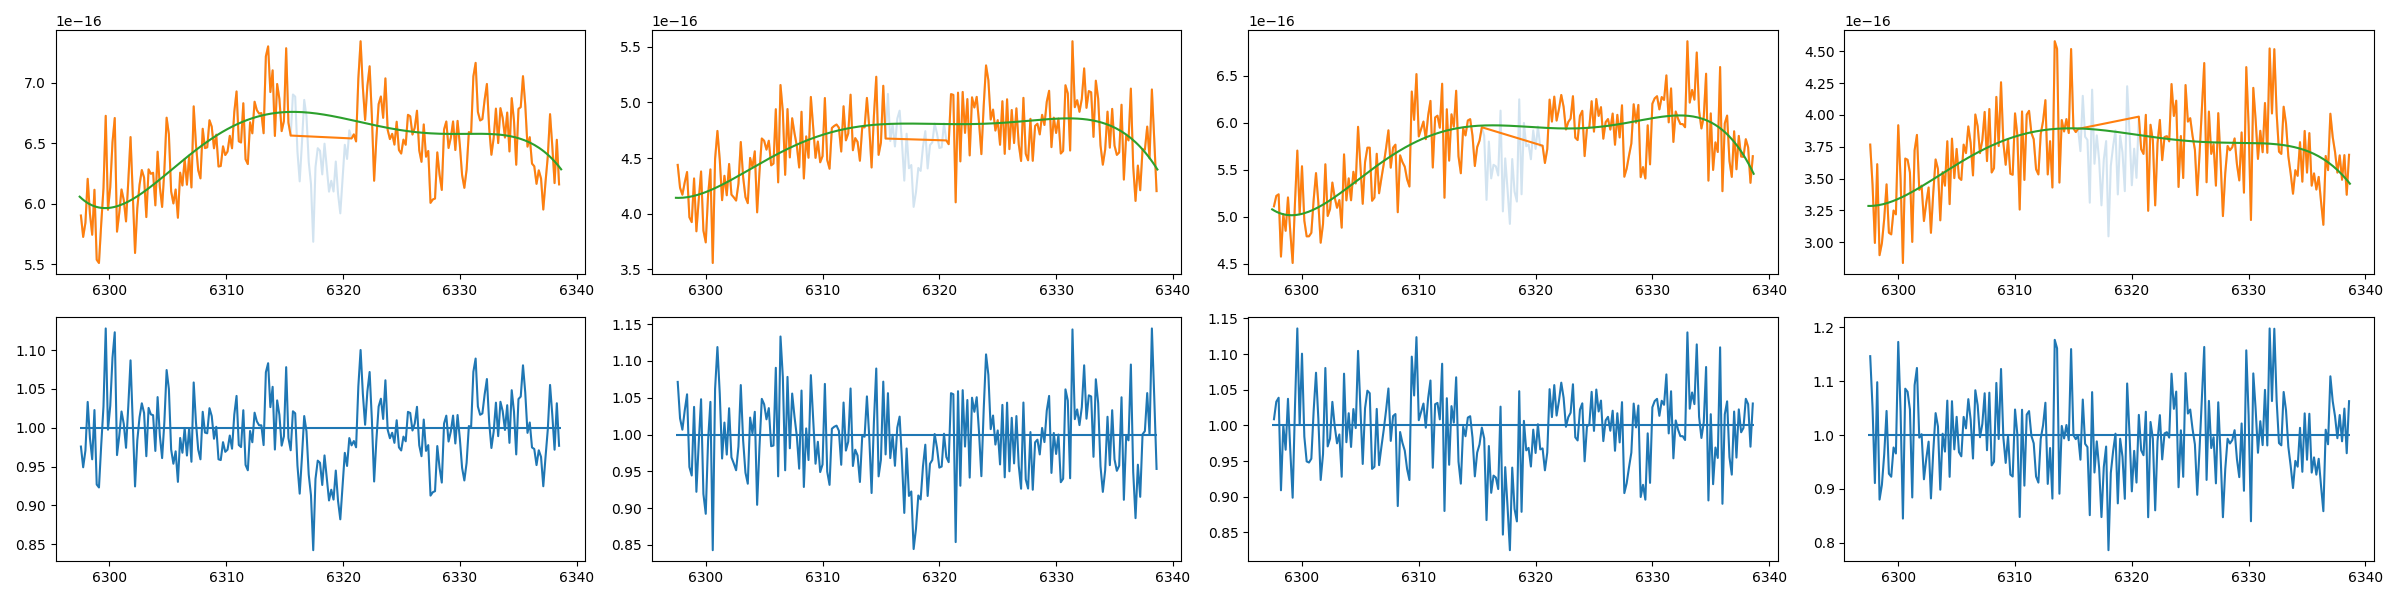

In [18]:
specnames = ['imacs1214','xsh0114', 'xsh0118', 'xsh0121']

fig, axes = plt.subplots(2,len(specnames),figsize=(24,6))


for i, specname in enumerate(specnames):
    spec = specs_22jli[specname]['spec']
    phase = specs_22jli[specname]['phase']
    xs = spec[:,0]
    ys = spec[:,1]
    yserr = np.ones_like(ys)*np.mean(ys)*0.05

    w1 = 6263*(1+z_22jli)
    w2 = 6304*(1+z_22jli)

    regmask = (xs>w1)*(xs<w2)
    xs = xs[regmask]
    ys = ys[regmask]
    yserr = yserr[regmask]

    fitmask =  np.ones_like(xs, dtype=bool)

    D2_w = 6283*(1+z_22jli)
    D1_w = 6284*(1+z_22jli)
    line_halfwidth = 2

    fitmask[(xs>(D1_w-line_halfwidth))*(xs<(D1_w+line_halfwidth))] = False
    fitmask[(xs>(D2_w-line_halfwidth))*(xs<(D2_w+line_halfwidth))] = False

    xsfit = xs[fitmask]
    ysfit = ys[fitmask]
    yserrfit = yserr[fitmask]


    #print(xsfit-np.mean(xsfit))
    #print(ysfit/np.max(ysfit))
    #print(yserrfit/np.max(ysfit))

    fitobj = polyfit(xsfit-np.mean(xsfit), ysfit/np.max(ysfit), yserrfit/np.max(ysfit), 5)

    ax = axes[0,i]
    ax.plot(xs, ys, alpha=0.2)
    ax.plot(xsfit, ysfit)
    ax.plot(np.linspace(w1, w2, 200), poly5(fitobj.params, np.linspace(w1, w2, 200)-np.mean(xsfit)) *np.max(ysfit) )

    ys_norm =  ys / (poly5(fitobj.params, xs-np.mean(xsfit)) *np.max(ysfit) )
    specnorm = np.array([xs, ys_norm]).transpose()
    np.savetxt('../data/spectra/%s_DIB6283_region_norm_host.txt'%specname, specnorm)

    ax2 = axes[1,i]
    ax2.plot(xs, ys_norm)
    ax2.hlines(1, xmin=w1, xmax=w2)
    
plt.tight_layout()

EW(DIB6283): 0.2714617185837104
EW(DIB6283): 0.22236628823047958
EW(DIB6283): 0.356423794922505
EW(DIB6283): 0.22022598493582127


<IPython.core.display.Javascript object>


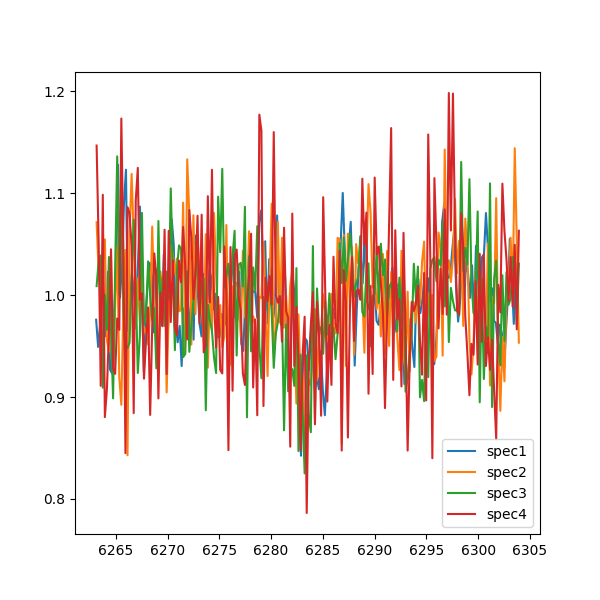

<IPython.core.display.Javascript object>


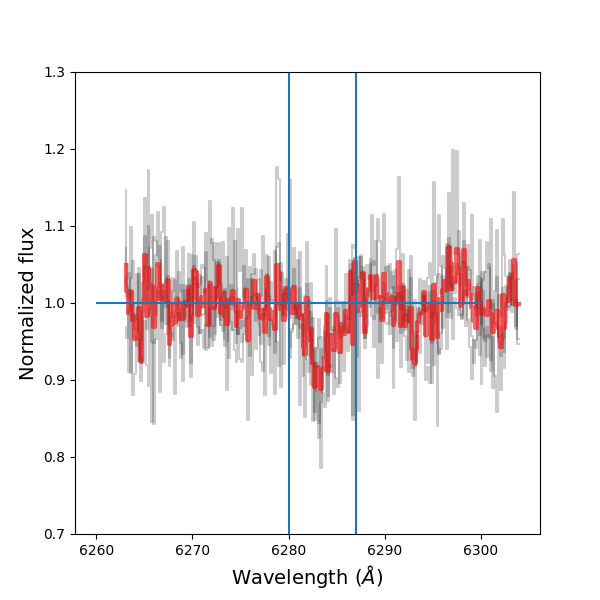

uncertainty per pixel
0.028437589737596445
EW(DIB6283): 0.2680396677189095
0.03485209323757853
E(B-V) [Lan2015]: 0.25430708512230504$\pm$0.033066502122939774
E(B-V)[Fan2019]: 0.2797908848840392$\pm$0.0363800555715851


<IPython.core.display.Javascript object>


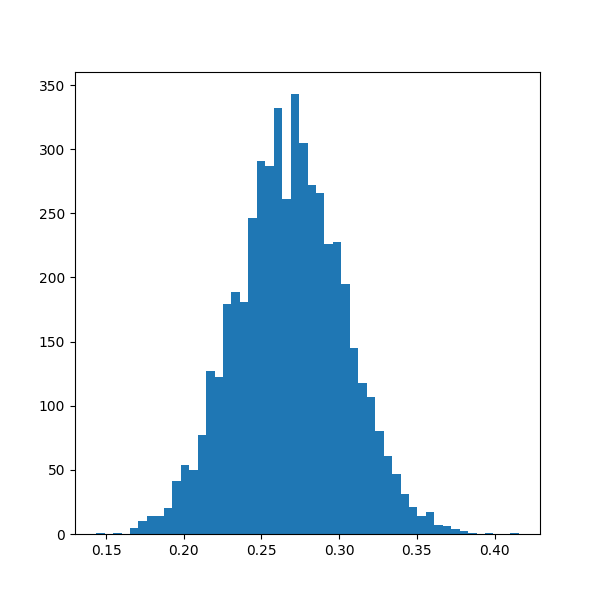

(array([  1.,   0.,   1.,   0.,   5.,  10.,  14.,  14.,  20.,  41.,  54.,
         50.,  77., 127., 122., 179., 189., 181., 246., 291., 287., 332.,
        261., 343., 305., 272., 266., 226., 228., 195., 145., 118., 107.,
         80.,  61.,  47.,  31.,  21.,  14.,  17.,   7.,   6.,   4.,   2.,
          1.,   0.,   1.,   0.,   0.,   1.]),
 array([0.14359303, 0.14903449, 0.15447595, 0.15991741, 0.16535887,
        0.17080033, 0.17624178, 0.18168324, 0.1871247 , 0.19256616,
        0.19800762, 0.20344908, 0.20889053, 0.21433199, 0.21977345,
        0.22521491, 0.23065637, 0.23609783, 0.24153928, 0.24698074,
        0.2524222 , 0.25786366, 0.26330512, 0.26874658, 0.27418804,
        0.27962949, 0.28507095, 0.29051241, 0.29595387, 0.30139533,
        0.30683679, 0.31227824, 0.3177197 , 0.32316116, 0.32860262,
        0.33404408, 0.33948554, 0.34492699, 0.35036845, 0.35580991,
        0.36125137, 0.36669283, 0.37213429, 0.37757575, 0.3830172 ,
        0.38845866, 0.39390012, 0.39934158, 0.

In [19]:

##DIB6283
# wmin = 6275
# wmax = 6290

wmin = 6280
wmax = 6287

spec1 = np.loadtxt('../data/spectra/imacs1214_DIB6283_region_norm_host.txt')
spec2 = np.loadtxt('../data/spectra/xsh0114_DIB6283_region_norm_host.txt')
spec3 = np.loadtxt('../data/spectra/xsh0118_DIB6283_region_norm_host.txt')
spec4 = np.loadtxt('../data/spectra/xsh0121_DIB6283_region_norm_host.txt')


#calculate EW from individual spectrum
for specdata in [spec1, spec2, spec3, spec4]:
    wavelength = specdata[:,0]
    flux = specdata[:,1]
    mask = (wavelength/(1+z_22jli)>wmin)*(wavelength/(1+z_22jli)<wmax)
    wavelength = wavelength[mask]
    flux = flux[mask]

    #sort the spectrum data, wavelength low to high
    sort_index = np.argsort(wavelength)
    wavelength  = wavelength[sort_index]
    flux = flux[sort_index]
    baseline = np.ones(len(wavelength))
    flux_net = 1.0 - flux
    EW = trapz(flux_net, x=wavelength)

    print('EW(DIB6283):', EW)



fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(spec1[:,0]/(1+z_22jli), spec1[:,1], label='spec1')
ax.plot(spec2[:,0]/(1+z_22jli), spec2[:,1], label='spec2')
ax.plot(spec3[:,0]/(1+z_22jli), spec3[:,1], label='spec3')
ax.plot(spec4[:,0]/(1+z_22jli), spec4[:,1], label='spec4')

ax.legend(loc=0)

specs_NaID = [spec1, spec2, spec3, spec4]
wavelength = spec2[:,0] #reference wavelength



fig, ax = plt.subplots(figsize=(6,6))

spec_fluxs = []

for spec in specs_NaID:
    spec_interpfunc = interp1d(spec[:,0], spec[:,1], bounds_error=False, fill_value='extrapolate')
    flux_interp = spec_interpfunc(wavelength)
    spec_fluxs.append(flux_interp)
    
    ax.step(wavelength/(1+z_22jli), flux_interp, alpha=0.2, color='k')
    
flux = np.average(np.array(spec_fluxs).transpose(), axis=1)

ax.step(wavelength/(1+z_22jli), flux, 'r', alpha=0.6, lw=3)  
ax.hlines(1., xmin=6260, xmax=6300)


ax.vlines([wmin, wmax], ymax=1.3, ymin=0.6, )

#ax.set_xlim([5908, 5940])
ax.set_ylim([0.7, 1.3])
ax.set_xlabel('Wavelength ($\AA$)', fontsize=14)
ax.set_ylabel('Normalized flux', fontsize=14)



plt.savefig('../plots/host_galaxy_DIB6283_lines.pdf')



wavelength =wavelength/(1+z_22jli)
print('uncertainty per pixel')
#print(flux[wavelength<6280])
print(np.std(flux[np.logical_or(wavelength<6280, wavelength>6287) ]))

mask = (wavelength>wmin)*(wavelength<wmax)
wavelength = wavelength[mask]
flux = flux[mask]
#sort the spectrum data, wavelength low to high
sort_index = np.argsort(wavelength)
wavelength  = wavelength[sort_index]
flux = flux[sort_index]


baseline = np.ones(len(wavelength))
flux_net = baseline - flux
EW = trapz(flux_net, x=wavelength)

print('EW(DIB6283):', EW)


EW_obs = EW

#do some estimate on the uncertainty of the measured EW



EWs_mcmc = []
for i in range(5000):
    flux_temp = flux.copy()
    flux_temp = flux_temp + np.random.randn(len(flux))*0.03
    
    mask = (wavelength>wmin)*(wavelength<wmax)
    wavelength = wavelength[mask]
    flux_temp = flux_temp[mask]
    #sort the spectrum data, wavelength low to high
    sort_index = np.argsort(wavelength)
    wavelength  = wavelength[sort_index]
    flux_temp = flux_temp[sort_index]
    baseline = np.ones(len(wavelength))
    flux_net = baseline - flux_temp
    EW = trapz(flux_net, x=wavelength)
    EWs_mcmc.append(EW)
    
e_EW = np.std(EWs_mcmc)
print(e_EW)
    
ebv1 = EW_obs/1.054
e_ebv1 = e_EW/1.054
print(r'E(B-V) [Lan2015]: %s$\pm$%s'%(ebv1, e_ebv1))
ebv2 = EW_obs/0.958
e_ebv2 = e_EW/0.958
print(r'E(B-V)[Fan2019]: %s$\pm$%s'%(ebv2, e_ebv2))    

fig,ax = plt.subplots(figsize=(6,6))
ax.hist(EWs_mcmc, bins=50)

### host absorption plot

<IPython.core.display.Javascript object>


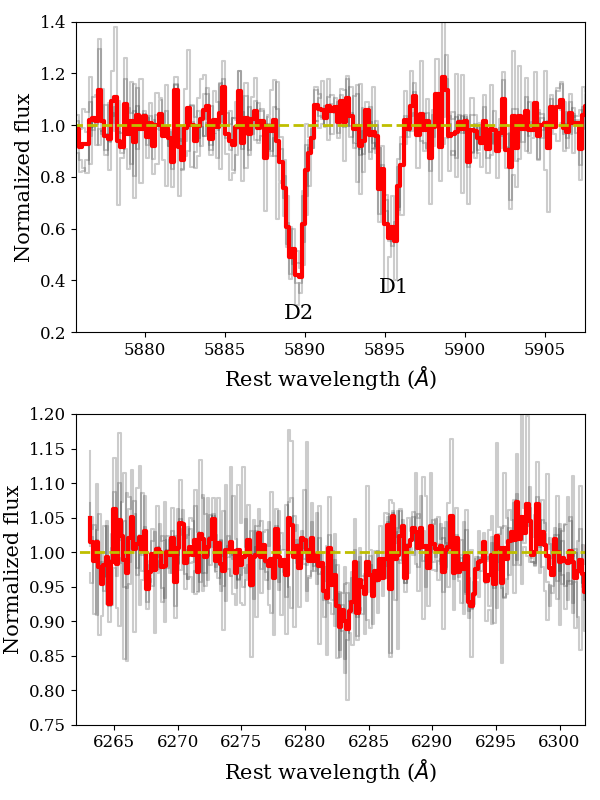

In [20]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'serif'

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(6, 8))


##Na I
spec1 = np.loadtxt('../data/spectra/imacs1214_sodium_region_norm_host.txt')
spec2 = np.loadtxt('../data/spectra/xsh0114_sodium_region_norm_host.txt')
spec3 = np.loadtxt('../data/spectra/xsh0118_sodium_region_norm_host.txt')
spec4 = np.loadtxt('../data/spectra/xsh0121_sodium_region_norm_host.txt')

specs_NaID = [spec1, spec2, spec3, spec4]
wavelength = spec2[:,0] #reference wavelength

spec_fluxs = []

for spec in specs_NaID:
    spec_interpfunc = interp1d(spec[:,0], spec[:,1], bounds_error=False, fill_value='extrapolate')
    flux_interp = spec_interpfunc(wavelength)
    spec_fluxs.append(flux_interp)
    ax1.step(wavelength/(1+z_22jli), flux_interp, alpha=0.2, color='k')
    
flux = np.average(np.array(spec_fluxs).transpose(), axis=1)
ax1.step(wavelength/(1+z_22jli), flux, 'r', alpha=1.0, lw=3)  
ax1.hlines(1., xmin=5905/(1+z_22jli), xmax=5945/(1+z_22jli), colors='y', lw=2, linestyles='dashed')

ax1.text(5928/(1+z_22jli), 0.35, 'D1', fontsize=15, ha='center')
ax1.text(5922/(1+z_22jli), 0.25, 'D2', fontsize=15, ha='center')

ax1.set_xlim([5908/(1+z_22jli), 5940/(1+z_22jli)])
ax1.set_ylim([0.2, 1.4])
ax1.tick_params(labelsize=12)
ax1.set_xlabel('Rest wavelength ($\AA$)', fontsize=15)
ax1.set_ylabel('Normalized flux', fontsize=15)


## DIB
spec1 = np.loadtxt('../data/spectra/imacs1214_DIB6283_region_norm_host.txt')
spec2 = np.loadtxt('../data/spectra/xsh0114_DIB6283_region_norm_host.txt')
spec3 = np.loadtxt('../data/spectra/xsh0118_DIB6283_region_norm_host.txt')
spec4 = np.loadtxt('../data/spectra/xsh0121_DIB6283_region_norm_host.txt')


specs_dib6283 = [spec1, spec2, spec3, spec4]
wavelength = spec2[:,0] #reference wavelength

spec_fluxs = []

for spec in specs_dib6283:
    spec_interpfunc = interp1d(spec[:,0], spec[:,1], bounds_error=False, fill_value='extrapolate')
    flux_interp = spec_interpfunc(wavelength)
    spec_fluxs.append(flux_interp)
    
    ax2.step(wavelength/(1+z_22jli), flux_interp, alpha=0.2, color='k')    
flux = np.average(np.array(spec_fluxs).transpose(), axis=1)

ax2.step(wavelength/(1+z_22jli), flux, 'r', alpha=1.0, lw=3)  
ax2.hlines(1., xmin=6260, xmax=6305, colors='y', lw=2, linestyles='dashed')

ax2.set_xlim([6262, 6302])
ax2.set_ylim([0.75, 1.2])
ax2.tick_params(labelsize=12)
ax2.set_xlabel('Rest wavelength ($\AA$)', fontsize=15)
ax2.set_ylabel('Normalized flux', fontsize=15)





plt.tight_layout()
plt.savefig('../plots/host_galaxy_NaID_DIB6283_lines.pdf')

<IPython.core.display.Javascript object>


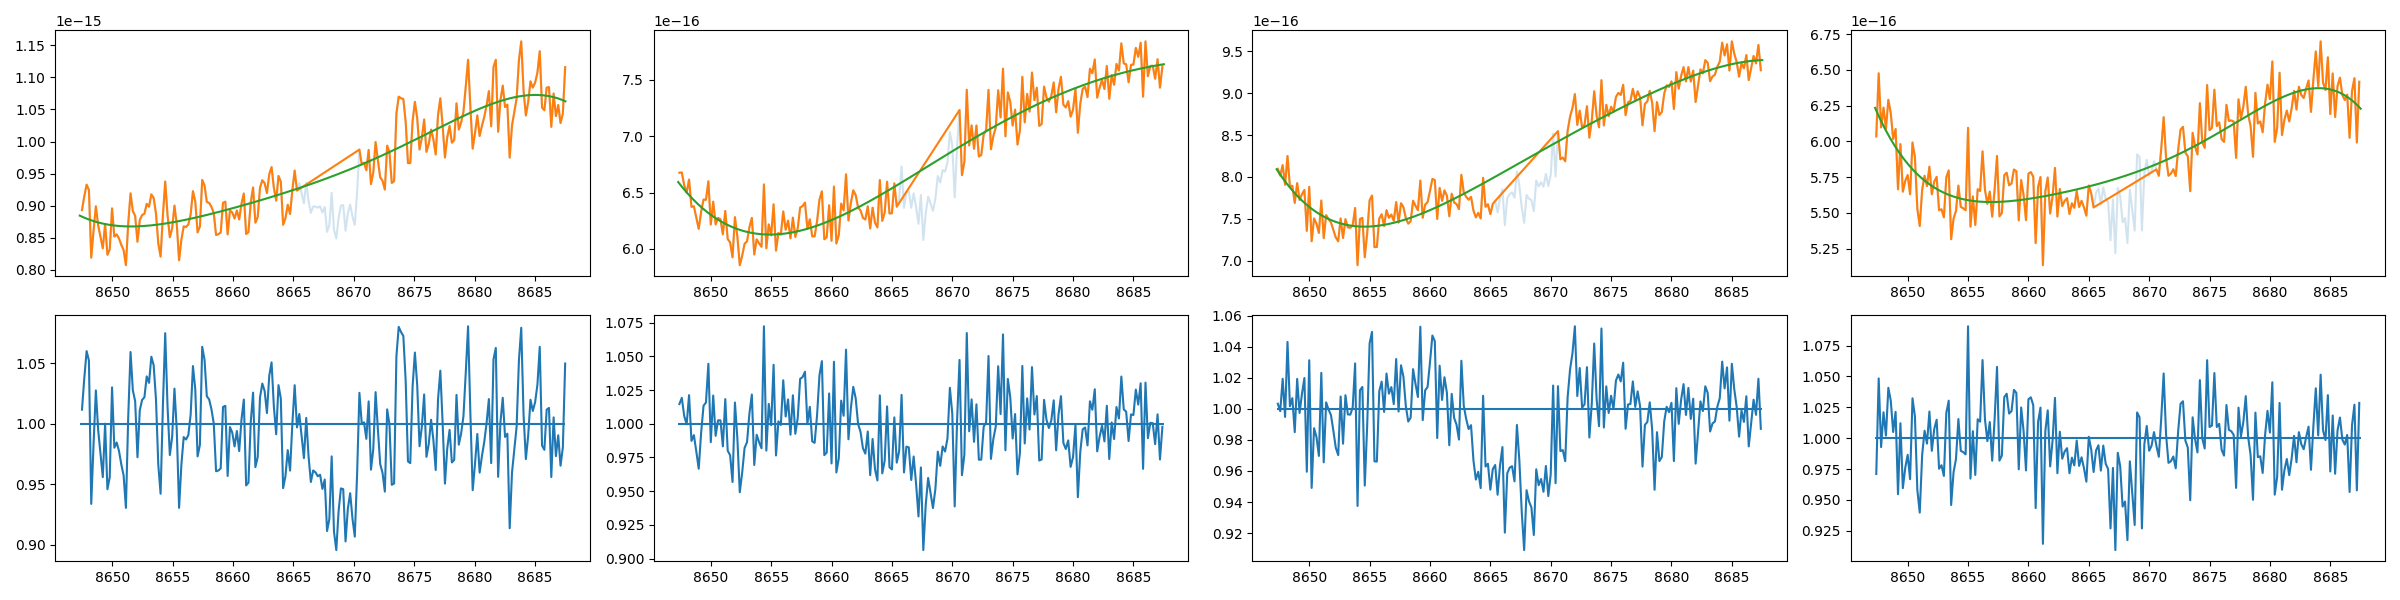

In [91]:
specnames = ['imacs1214','xsh0114', 'xsh0118', 'xsh0121']

fig, axes = plt.subplots(2,len(specnames),figsize=(24,6))


for i, specname in enumerate(specnames):
    spec = specs_22jli[specname]['spec']
    phase = specs_22jli[specname]['phase']
    xs = spec[:,0]
    ys = spec[:,1]
    yserr = np.ones_like(ys)*np.mean(ys)*0.05

    w1 = 8600*(1+z_22jli)
    w2 = 8640*(1+z_22jli)

    regmask = (xs>w1)*(xs<w2)
    xs = xs[regmask]
    ys = ys[regmask]
    yserr = yserr[regmask]

    fitmask =  np.ones_like(xs, dtype=bool)

    D2_w = 8620*(1+z_22jli)
    D1_w = 8621*(1+z_22jli)
    line_halfwidth = 2

    fitmask[(xs>(D1_w-line_halfwidth))*(xs<(D1_w+line_halfwidth))] = False
    fitmask[(xs>(D2_w-line_halfwidth))*(xs<(D2_w+line_halfwidth))] = False

    xsfit = xs[fitmask]
    ysfit = ys[fitmask]
    yserrfit = yserr[fitmask]


    #print(xsfit-np.mean(xsfit))
    #print(ysfit/np.max(ysfit))
    #print(yserrfit/np.max(ysfit))

    fitobj = polyfit(xsfit-np.mean(xsfit), ysfit/np.max(ysfit), yserrfit/np.max(ysfit),5)

    ax = axes[0,i]
    ax.plot(xs, ys, alpha=0.2)
    ax.plot(xsfit, ysfit)
    ax.plot(np.linspace(w1, w2, 200), poly5(fitobj.params, np.linspace(w1, w2, 200)-np.mean(xsfit)) *np.max(ysfit) )

    ys_norm =  ys / (poly5(fitobj.params, xs-np.mean(xsfit)) *np.max(ysfit) )
    specnorm = np.array([xs, ys_norm]).transpose()
    np.savetxt('../data/spectra/%s_DIB8620_region_norm_host.txt'%specname, specnorm)

    ax2 = axes[1, i]
    ax2.plot(xs, ys_norm)
    ax2.hlines(1, xmin=w1, xmax=w2)
    
plt.tight_layout()

<IPython.core.display.Javascript object>


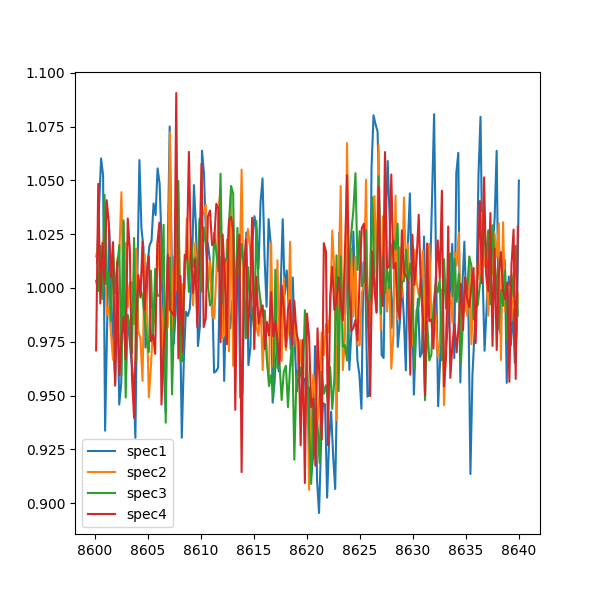

<IPython.core.display.Javascript object>


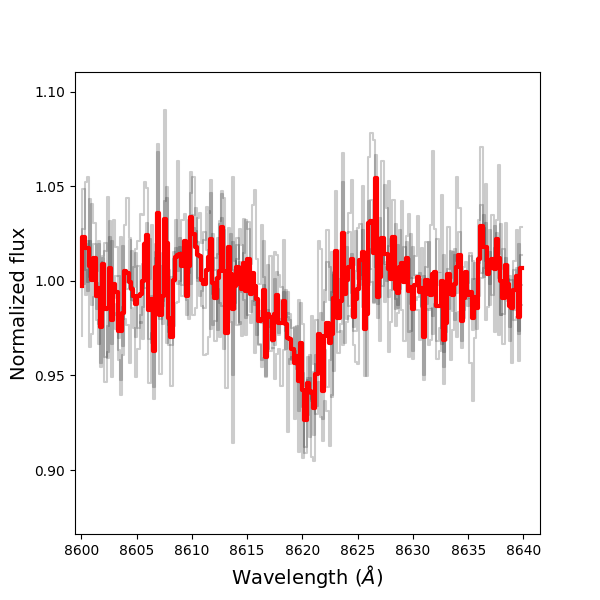

EW(DIB8620): 0.1857441176557945


In [173]:
spec1 = np.loadtxt('./spectra/imacs1214_DIB8620_region_norm_host.txt')
spec2 = np.loadtxt('./spectra/xsh0114_DIB8620_region_norm_host.txt')
spec3 = np.loadtxt('./spectra/xsh0118_DIB8620_region_norm_host.txt')
spec4 = np.loadtxt('./spectra/xsh0121_DIB8620_region_norm_host.txt')


fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(spec1[:,0]/(1+z_22jli), spec1[:,1], label='spec1')
ax.plot(spec2[:,0]/(1+z_22jli), spec2[:,1], label='spec2')
ax.plot(spec3[:,0]/(1+z_22jli), spec3[:,1], label='spec3')
ax.plot(spec4[:,0]/(1+z_22jli), spec4[:,1], label='spec4')

ax.legend(loc=0)

specs_NaID = [spec1, spec2, spec3, spec4]
wavelength = spec2[:,0] #reference wavelength



fig, ax = plt.subplots(figsize=(6,6))

spec_fluxs = []

for spec in specs_NaID:
    spec_interpfunc = interp1d(spec[:,0], spec[:,1], bounds_error=False, fill_value='extrapolate')
    flux_interp = spec_interpfunc(wavelength)
    spec_fluxs.append(flux_interp)
    
    ax.step(wavelength/(1+z_22jli), flux_interp, alpha=0.2, color='k')
    
flux = np.average(np.array(spec_fluxs).transpose(), axis=1)

ax.step(wavelength/(1+z_22jli), flux, 'r', lw=3)  

#ax.text(5928, 0.35, 'D2', fontsize=15, ha='center')
#ax.text(5922, 0.25, 'D1', fontsize=15, ha='center')

#ax.set_xlim([5908, 5940])
ax.set_ylim([0.6, 1.2])
ax.set_xlabel('Wavelength ($\AA$)', fontsize=14)
ax.set_ylabel('Normalized flux', fontsize=14)


plt.savefig('./plots/host_galaxy_DIB6283_lines.pdf')



##DIB6283
wmin = 8617
wmax = 8622
baseline = 1
absorption = 1
wavelength = wavelength/(1+z_22jli)
mask = (wavelength>wmin)*(wavelength<wmax)
wavelength = wavelength[mask]
flux = flux[mask]

#sort the spectrum data, wavelength low to high
sort_index = np.argsort(wavelength)
wavelength  = wavelength[sort_index]
flux = flux[sort_index]


if baseline != 1:
        raise ValueError("we don't support non-normalized spectrum yet... please normalize your spectrum first please")
else:
        baseline = np.ones(len(wavelength))
    
if absorption:
        flux_net = baseline - flux
else:
        flux_net = flux - baseline

EW = trapz(flux_net, x=wavelength)

print('EW(DIB8620):', EW)